In [102]:
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import swan
from importlib import reload
reload(swan)

# swan defaults
nx = 5
ny = 6

n = nx * ny
nsigma = 4
ntheta = 3 # full is ntheta * ntheta

# load input data
wd = os.path.join('..')
datadir = os.path.join(wd, "data_temp")
u10 = np.load(os.path.join(datadir, "speed.npz"))['array'][:ny, :nx]
theta = np.load(os.path.join(datadir, "direction.npz"))['array'][:ny, :nx]
swh = np.load(os.path.join(datadir, "sig_waves.npz"))['array'][:ny, :nx]
bathy = np.load(os.path.join(datadir, "bathymetry.npz"))['array'][:ny, :nx]
land = [bathy < 0]
bathy[bathy < 0] = 1e-5 # check correct solution here later

dx = np.load(os.path.join(datadir, "bathymetry.npz"))['mesh'].item()
dy = dx

# redo in case nx or ny out of bounds
ny, nx = u10.shape
n = nx * ny
dims = [ntheta, nsigma, ny, nx]

# spectral grid
sigmas = np.linspace(0.05, 0.4, nsigma)
thetas1 = np.linspace(0, np.pi/2, ntheta)
thetas2 = np.linspace(np.pi/2, np.pi, ntheta)
thetas3 = np.linspace(-np.pi/2, -np.pi, 3)
thetas4 = np.linspace(0, -np.pi/2, 3)
theta_sweeps = [thetas1, thetas2, thetas3, thetas4]

stepθ = 1
stepσ = ntheta
stepy = stepσ * nsigma
stepx = stepy * ny

dsigma = sigmas[1] - sigmas[0]

## Sweep $n$

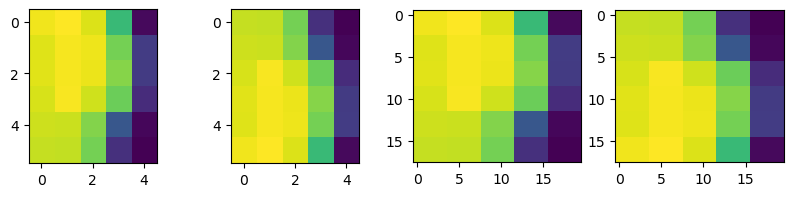

In [103]:
# check everything is being flipped correctly
sweep = 3
fig, axs = plt.subplots(1, 4, figsize=(10, 2))
axs[0].imshow(bathy)
axs[1].imshow(swan.flip_for_sweep(bathy, sweep))
_, _, H  = np.meshgrid(thetas, sigmas, bathy.ravel(order=swan.order), indexing='ij')
axs[2].imshow(swan.flattened_meshgrid(H, dims, which='z'))
_, _, H  = np.meshgrid(thetas, sigmas, swan.flip_for_sweep(bathy, sweep).ravel(order=swan.order), indexing='ij')
axs[3].imshow(swan.flattened_meshgrid(H, dims, which='z'));

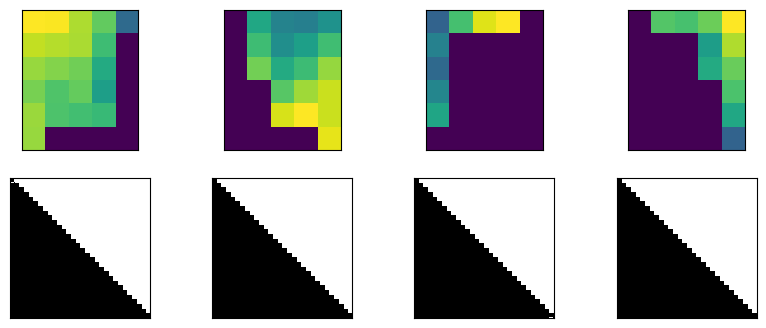

In [87]:
dt = 1
N_sweeps = []
A_sweeps = []
for sweep in range(4):
    thetas = theta_sweeps[sweep]
    dtheta = thetas[1] - thetas[0]

    # make meshgrids for all the inputs
    *_, H  = np.meshgrid(thetas, sigmas, swan.flip_for_sweep(bathy, sweep).ravel(order=swan.order), indexing='ij')
    *_, θm  = np.meshgrid(thetas, sigmas, swan.flip_for_sweep(theta, sweep).ravel(order=swan.order), indexing='ij') # wind dir (assume mean wave dir)
    θ, Σ, U10  = np.meshgrid(thetas, sigmas, swan.flip_for_sweep(u10, sweep).ravel(order=swan.order), indexing='ij')

    # initial energy distribution
    Ef = swan.spectrum_pm(Σ, U10)
    fpeak = swan.peak_frequency_pm(U10) / (2 * np.pi)
    D = swan.cos2_model(θ, θm)
    E = Ef * D
    N = E / Σ
    N_sweeps.append(N)

    # velocities
    K = swan.inverse_dispersion_approx(Σ, H)
    c = swan.phase_speed(K, Σ)
    cg = swan.group_velocity(K, H, Σ)
    cx, cy = swan.spatial_group_velocity(cg, θ)
    cθ = swan.directional_velocity(θ, c, cg, stepx, stepy, dx, dy)
    # cσ = ...

    # update matrices
    A_geo = swan.bsbt_matrix(stepx, stepy, cx, cy, dx, dy)
    A_spectral = swan.theta_block_matrix(cθ, stepθ)
    A = A_spectral + A_geo
    I = np.eye(ntheta * nsigma * ny * nx)
    A_sweeps.append(np.linalg.inv(I + dt * A))
    
fig, axs = plt.subplots(2, 4, figsize=(10, 4))
for ax, N in zip(axs[0, :], N_sweeps):
    ax.imshow(N[1, 1, :].reshape([ny, nx], order=swan.order))
    ax.set_xticks([])
    ax.set_yticks([])
for ax, A in zip(axs[1, :], A_sweeps):
    ax.spy(A)
    ax.set_xticks([])
    ax.set_yticks([])

In [92]:
N1_sweeps = []
for A, N in zip(A_sweeps, N_sweeps):
    N1 = A @ N.ravel(order=swan.order)
    N1_sweeps.append(N1.reshape([ntheta, nsigma, ny, nx], order=swan.order))

In [93]:
N1 = 0
for sweep, N1_sweep in enumerate(N1_sweeps):
    N1 += swan.flip_for_sweep(N1_sweep, sweep)

In [97]:
E0 = 
E = N1 * Σ.reshape([ntheta, nsigma, ny, nx], order=swan.order)
Hs = swan.significant_wave_height(E, dtheta, 1)

/Users/alison/Documents/DPhil/numerical-wave-models/swan/swan/relations_out.py:62: RuntimeWarning: invalid value encountered in sqrt
  """Significant wave height across spatial grid."""


In [101]:
N

NameError: name 'N0' is not defined

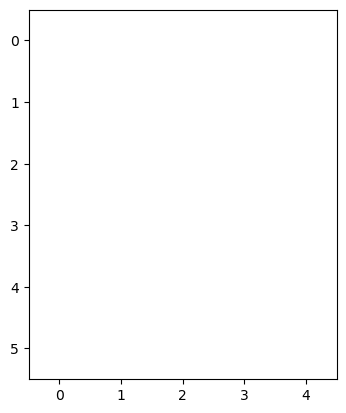

In [100]:
plt.imshow(Hs)